## Library Imports

In [ ]:
!pip install pymatching
!pip install matplotlib
!pip install networkx
!pip install numpy
!pip install pandas
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.4/619.4 kB 8.3 MB/s eta 0:00:00


In [ ]:
import time
import math
import random
import itertools
import pymatching
import collections
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter

## Lattice Generation

Now, we generate the whole Lattice. This is using the 6-qubit RSG figure from the FBQC paper: https://arxiv.org/pdf/2101.09310

In [ ]:
""" Some simple helper functions """

def calculate_distances(point, points_list):
    """
    point is the reference point as a tuple (x1, y1, z1)
    points_list is a list of points [(x2, y2, z2), ...]
    """
    distances = []
    for p in points_list:
        dist = np.linalg.norm(np.array(point) - np.array(p))
        distances.append(round(dist, 2))  # Round the distance to 2 decimal places

    return distances

def find_indices_with_distance(distances, target_distance, tolerance=1e-2):
    """
    Find all indices where the distance is approximately equal to the target distance
    """
    indices = [i for i, dist in enumerate(distances) if abs(dist - target_distance) < tolerance]
    return indices

def return_points_on_edge(points, side_length, filter=True):
    """
    Filter points which are on the edge
    """
    relevant     = []
    not_relevant = []
    for point in points:
        (x,y,z) = point
        if (((x%side_length==0) and (y%side_length==0)) or
            ((y%side_length==0) and (z%side_length==0)) or
            ((x%side_length==0) and (z%side_length==0))):
            relevant.append(point)
        else:
            not_relevant.append(point)

    if filter:
        return relevant
    else:
        return not_relevant

def check_tuple_in_sublists(big_list, index2, coord_tuple):
    """
    Check if a tuple of coordinates from one sublist is present in another sublist.
    Accounts for order reversals.

    :param big_list: List containing the sublists
    :param index2: Index of the second sublist to compare against
    :param coord_tuple: Tuple of coordinates to check
    :return: Boolean indicating presence
    """
    sublist2 = big_list[index2]

    # Check if the tuple or its reverse is present in the second sublist
    return coord_tuple in sublist2 or coord_tuple[::-1] in sublist2

In [ ]:
""" Now, let's generate the Lattice, the Lattice has sparse connections (only two RSGs per lattice) """
side_length=6
unit = side_length/6

def make_RSG(start):
    """
    Function to make one RSG on the cube
    """
    (x0, y0, z0) = start
    photons   = [(x0+2*unit, y0,        z0),
                 (x0,        y0+2*unit, z0),
                 (x0+2*unit, y0+2*unit, z0),
                 (x0+2*unit, y0,        z0+2*unit),
                 (x0,        y0,        z0+2*unit),
                 (x0,        y0+2*unit, z0+2*unit)]
    return photons

def make_one_cube(origin):
    """
    Function to make one cube (2 RSGs - for 6 ring Resource States)
    """
    all_points = []
    photons = make_RSG(origin)
    all_points.append(photons)

    (x0, y0, z0) = origin
    new_start = (x0+4*unit,y0+4*unit,z0+4*unit)
    photons = make_RSG(new_start)
    all_points.append(photons)
    return all_points

def make_lattice(num_x, num_y, num_z):
    """
    Function to make the complete lattice
    """
    total_cubes = num_x*num_y*num_z

    ##Find all relevant start points
    x = np.array(list(range(num_x)))*side_length
    y = np.array(list(range(num_y)))*side_length
    z = np.array(list(range(num_z)))*side_length
    points = list(np.array(np.meshgrid(x, y, z)).T.reshape(-1, 3))

    ##Get the coordinates for each cube (2 RSGs)
    cubes = []
    lattice_photons = []
    for start in points:
        photons = make_one_cube(start)
        lattice_photons.append(photons)

        (x0, y0, z0) = start
        cubes.append((x0+3*unit, y0+3*unit, z0+3*unit))

    ##Now understand which cubes will be participating in the fusion process
    neighbor_cubes = []
    for cube in cubes:
        distances = calculate_distances(cube, cubes)
        indices   = find_indices_with_distance(distances, round(6*math.sqrt(3), 2))+\
                    find_indices_with_distance(distances, round(6*math.sqrt(2), 2))+\
                    find_indices_with_distance(distances, round(6*math.sqrt(1), 2))
        indices.sort()
        neighbor_cubes.append(indices)

    ##Now find out the coordinates of photons which will participate in the fusion
    all_fusions = []
    for idx,neighbors in enumerate(neighbor_cubes):
        current_points = lattice_photons[idx][0] + lattice_photons[idx][1]

        cube_fusions = []
        for point in current_points:
            for nidx in neighbors:
                other_points = lattice_photons[nidx][0] + lattice_photons[nidx][1]
                (xp, yp, zp) = point
                """
                The kind of connections you have when a point is on the edge is different
                from when the point is on the face, we have that distinction here
                """
                if ( ((xp % side_length)==0 and (yp % side_length)==0) or
                     ((yp % side_length)==0 and (zp % side_length)==0) or
                     ((xp % side_length)==0 and (zp % side_length)==0) ):

                    _ = return_points_on_edge(other_points, side_length)
                    distances = calculate_distances(point, _)
                    indices = find_indices_with_distance(distances, round(2*math.sqrt(1), 2))
                    cube_fusions.extend([(point, _[index]) for index in indices])
                else:
                    _ = return_points_on_edge(other_points, side_length, filter=False)
                    distances = calculate_distances(point, _)
                    indices = find_indices_with_distance(distances, round(2*math.sqrt(2), 2))
                    cube_fusions.extend([(point, _[index]) for index in indices])
        all_fusions.append(cube_fusions)

    ##Now find the syndrome string for each fusion for pymatching
    syndrome_map = collections.OrderedDict()
    for idx,fusions in enumerate(all_fusions):
        indices = list(range(len(all_fusions)))
        indices.remove(idx)

        for fusion in fusions:
            syndrome = [0]*total_cubes
            syndrome[idx] = 1
            for i in indices:
                active = check_tuple_in_sublists(all_fusions, i, fusion)
                if active: syndrome[i] = 1;
            syndrome_map[fusion] = syndrome

    ##Form a unique fusion list
    all_fusions = []
    for key in syndrome_map.keys():
        if ((key[0], key[1]) in all_fusions) or ((key[1], key[0]) in all_fusions):
            pass
        else:
            all_fusions.append(key)

    ##Trim the syndrome map based on this
    duplicates = [key for key in syndrome_map.keys() if key not in all_fusions]
    for key in duplicates:
        del syndrome_map[key]

    return syndrome_map, lattice_photons

In [ ]:
num_x = 8
num_y = 8
num_z = 2
syndrome_map, lattice_photons = make_lattice(num_x, num_y, num_z)

# **MWPM: Surface Codes Example**

In [ ]:
"""
Getting software decoding latency numbers (Example pymatching usecase)
The below example is for Surface Codes, we will do the photonics equivalent in the next cell
"""
# Example parity-check matrix for a small 3x3 surface code
# This matrix has rows representing stabilizer checks and columns representing qubits
# An entry of 1 means that the qubit is part of the stabilizer
H = np.array([
    [1, 0, 1, 0, 0, 0, 0, 0, 0],  # Z-checks
    [0, 1, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 0, 0],
    [1, 0, 0, 0, 1, 0, 0, 0, 1],
    [0, 1, 0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 1]
])

# Create a matching decoder using the parity-check matrix
matching = pymatching.Matching(H)

# Simulate an error: let's say an error occurred on qubit 0
error = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0])  # Error vector with a bit flip on qubit 0

# Find syndrome: this step finds which stabilizers are violated due to the error
syndrome = H @ error % 2
print(f"Syndrome: {syndrome}")

# Decode: use the syndrome to find the correction
start = time.perf_counter_ns()
correction = matching.decode(syndrome)
end = time.perf_counter_ns()
print(f"Correction: {correction}")

# Verify: check if the correction matches the error
is_corrected = np.array_equal((error + correction) % 2, np.zeros_like(error))
print(f"Error corrected: {is_corrected}")

# Time: print the time it took to decode the syndrome graph
total_time = end - start
print(f"Time taken for correction is: {total_time}ns")

Syndrome: [1 0 0 0 1 0 0]
Correction: [1 0 0 0 0 0 0 0 0]
Error corrected: True
Time taken for correction is: 254985ns


# **MWPM Photonics**

In [ ]:
fusion_bits = len(list(syndrome_map.keys()))
syndrome_bits = len(list(syndrome_map.values())[0])
mwpm_input = np.array([[0 for col in range(fusion_bits)] for row in range(syndrome_bits)])

fusion_list = list(syndrome_map.keys())
for fusion,syndrome in syndrome_map.items():
    fidx = fusion_list.index(fusion)
    sidxs = [i for i, value in enumerate(syndrome) if value == 1]

    for sidx in sidxs:
        mwpm_input[sidx][fidx] = 1

matching = pymatching.Matching(mwpm_input)

In [ ]:
print("Data: fusion bits = {}, syndrome bits = {}, total bits = {}".format(fusion_bits, syndrome_bits, fusion_bits*syndrome_bits))

Data: fusion bits = 498, syndrome bits = 128, total bits = 63744


In [ ]:
nsims = 20000
error_rate   = 0.40
hamming_dict = dict()
timing_db = dict()
progress_bar = tqdm(total=nsims, desc="Simulation Progress")

sim = 1
while(sim <= nsims):
    ##Make the error string
    error = []
    for fusion in fusion_list:
        random_number = random.randint(1, 100)
        if (random_number <= error_rate*100):
            error.append(1)
        else:
            error.append(0)

    ##Initialize functions for hamming weight
    syndrome = mwpm_input @ error % 2
    hamming_weight = list(syndrome).count(1)
    hamming_dict.setdefault(hamming_weight,0)
    timing_db.setdefault(hamming_weight, 0)
    hamming_dict[hamming_weight] += 1

    ##Find the syndrome string & decode
    start = time.perf_counter_ns()
    correction = matching.decode(syndrome)
    end = time.perf_counter_ns()
    total_time = (end - start)/1000000

    ##Record the time taken for decode
    timing_db[hamming_weight] += total_time
    progress_bar.update(1)
    sim += 1
progress_bar.update(1)

##Normalize the times in both hamming dict & timing db
for i in range(1, syndrome_bits+1):
    hamming_dict.setdefault(i,0)
    timing_db.setdefault(i,0)

    if (hamming_dict[i] != 0):
        timing_db[i] = timing_db[i]/hamming_dict[i]

    hamming_dict[i] = hamming_dict[i]/nsims

Simulation Progress: 20001it [04:32, 73.48it/s] 
Simulation Progress: 100%|█████████▉| 19987/20000 [02:58<00:00, 140.18it/s]

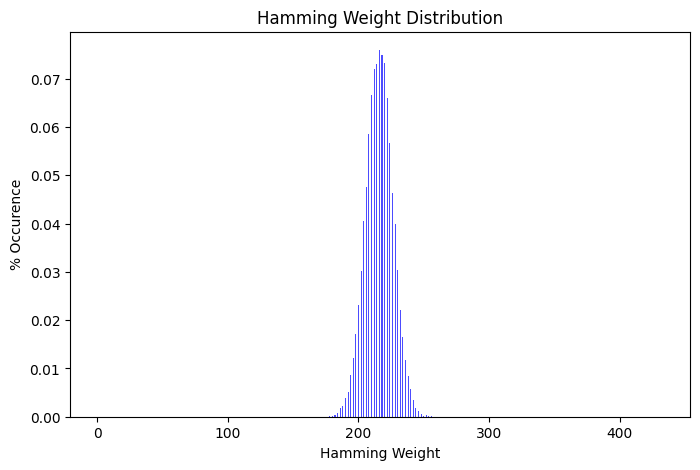

In [ ]:
x = list(range(1, syndrome_bits+1))
y = [hamming_dict[i] for i in x]

# Create a single bar plot
plt.figure(figsize=(8, 5))
plt.bar(x, y, color='blue', alpha=0.7)

# Add labels and title
plt.title('Hamming Weight Distribution')
plt.xlabel('Hamming Weight')
plt.ylabel('% Occurence')

# Show plot
plt.show()

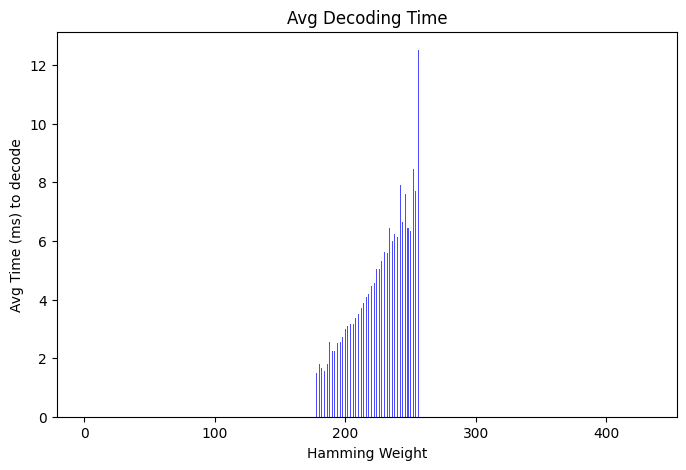

In [ ]:
x = list(range(1, syndrome_bits+1))
y = [timing_db[i] for i in x]

# Create a single bar plot
plt.figure(figsize=(8, 5))
plt.bar(x, y, color='blue', alpha=0.7)

# Add labels and title
plt.title('Avg Decoding Time')
plt.xlabel('Hamming Weight')
plt.ylabel('Avg Time (ms) to decode')

# Show plot
plt.show()